# Week 6

In this lecture we cover some methods for building models when your dataset doesn't fit in-memory on your local machine. Then, we'll discuss a covering algorithm and the K nearest neighbors algorithm. 

**Table of Contents**

-   [Modeling with "Big" Data](#big-data)
    -   [H2O](#h2o)
        -   [H2O Architecture](#architecture)
        -   [Cluster Creation](#cluster)
        -   [H2O Basics](#basics)
        -   [City Bike Demonstration](#demo)
-   [Rule Construction with Covering](#covering)
-   [Instance-Based Learning with Nearest Neighbors](#knn)   

<a id='big-data'></a>
## Modeling with "Big" Data

Sometimes the dataset that is the target for your analyses is too big to fit onto your laptop, or local workstation. However, your organization might have large computing resources, which are maintained by the IT department, or possess a cloud service account, like AWS, where large computing resources can be easily created. In some cases, it might be perfectly acceptable to install R Studio Server or Jupyter Hub Server, for example, on one of these larger machines to accomplish your analysis task. However, there are tools that exist, which can make greater use of your computing resources, from a machine learning perspective. We're going to cover how a couple of these tools can be harnessed to enhance your machine learning abilities.

<a id='h2o'></a>
### H2O

[H2O](https://www.h2o.ai/) is an in-memory, parallel, distributed machine learning platform. It provides a number of open source tools for data ingestion and preparation and model building and persistence. They even offer commercial solutions for "automatic" machine learning. The open source tools are written in Java, and you can freely download the Java package from their website. If you are a Java programmer, this may be the API you want to use. If you are not interested in using the Java API, H2O also offers a Python package and an R library. 

When dealing with large datasets, there are a number of hurdles that you must overcome to complete your analyses. One of them is memory resources. It's difficult to build machine learning models quickly if you can't hold the dataset in memory. Time is also a limited resource. What ever happened to [Mahout](https://mahout.apache.org/)? It might not be acceptable to take weeks to build your machine learning model. Machine learning systems that can handle large amounts of data and can build models quickly, have become valuable. Both H2O and Spark [MLlib](https://spark.apache.org/mllib/) have implemented model-building systems that are parallelized, and can run distributed across clusters of machines. They can potentially run much faster than a single-threaded R or Python implementation, and can also harness ALL of the machines in your cluster, rather than a single machine. This may expand your memory pool, and enable new analysis opportunities.

<a id='architecture'></a>
#### H2O Architecture

The H2O computing engine runs in a Java Virtual Machine (JVM). While it's possible to harness the H2O library strictly from the Java API, it's common to interact with H2O through the REST API. H2O runs an HTTP server and there are multiple REST-based interfaces, such as R, Python, or the browser-based interface called Flow, which can be used to utilize H2O. Here's an [architecture](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/architecture.html#) overview of a single H2O instance.

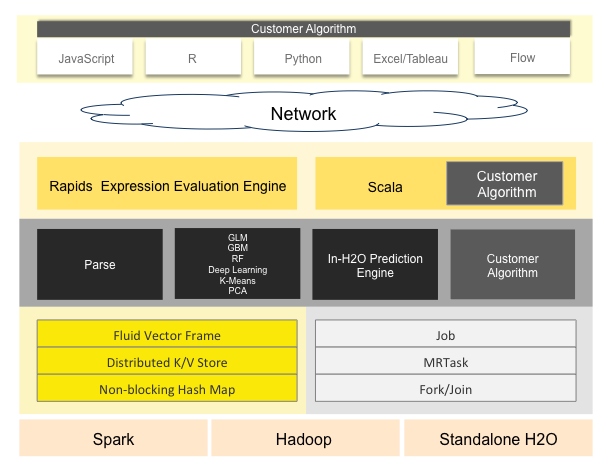

In [1]:
from IPython.display import Image
Image(filename='h2o_stack.png') 

It's also possible to group multiple H2O instances together to form a cloud, or *cluster*, of H2O instances. We'll discuss how to create an H2O cluster next.

<a id='cluster'></a>
#### Cluster Creation

So, how can we use H2O to handle "big" data? First, we have to construct an H2O *cluster*. Here, a cluster is 1 or more machines, with each machine running an H2O server, connected to each other. You could run the H2O server on your laptop, or local workstation, but in order to harness large computing resources, the H2O servers are usually run on organizational infrastructure. For demonstration purposes, we'll create a 2-node H2O cluster in my AWS subnet. Here's the CloudFormation template I used to achieve this.

```YAML
AWSTemplateFormatVersion: '2010-09-09'
Description: 'H2O Cluster'
Resources:
  H2OInstance0:
    Type: 'AWS::EC2::Instance'
    Properties:
      InstanceType: 'a1.2xlarge'
      ImageId: 'ami-0dcd8f62a00af3d76'
      NetworkInterfaces: 
        - DeviceIndex: 0
          GroupSet: 
            - Ref: CS4315Summer2019SecurityGroupH2O
          PrivateIpAddress : '192.168.28.185'
          SubnetId: 'subnet-09e1bc3eb37714763'
      BlockDeviceMappings:
      - DeviceName: '/dev/sda1'
        Ebs:
          VolumeSize: 300
      UserData: 
        Fn::Base64: !Sub |
          #!/bin/bash
          # Resize root volume
          /sbin/resize2fs /dev/sda

          # Download Java JDK from S3
          apt-get -y update
          apt -y install awscli
          aws s3 cp s3://dsag-java-8/jdk-8u221-linux-arm64-vfp-hflt.tar.gz ./ --region us-east-2 --no-sign-request
          tar -xvf jdk-8u221-linux-arm64-vfp-hflt.tar.gz
          mkdir -p /usr/lib/jvm
          mv ./jdk1.8.0_221 /usr/lib/jvm/
          update-alternatives --install "/usr/bin/java" "java" "/usr/lib/jvm/jdk1.8.0_221/bin/java" 1
          update-alternatives --install "/usr/bin/javac" "javac" "/usr/lib/jvm/jdk1.8.0_221/bin/javac" 1
          chmod a+x /usr/bin/java
          chmod a+x /usr/bin/javac
          chown -R root:root /usr/lib/jvm/jdk1.8.0_221

          # Download H2O and start it up
          apt-get -y install zip unzip
          wget http://h2o-release.s3.amazonaws.com/h2o/rel-yau/1/h2o-3.26.0.1.zip
          unzip h2o-3.26.0.1.zip
          cd h2o-3.26.0.1
          echo "192.168.28.185:80" >> h2o_nodes
          echo "192.168.28.244:80" >> h2o_nodes
          java -jar h2o.jar -flatfile h2o_nodes -port 80
      Tags:
        -
          Key: Name
          Value: H2OInstance0
      KeyName: 'CS4315Summer2019-Key-Share'
  H2OInstance1:
    Type: 'AWS::EC2::Instance'
    Properties:
      InstanceType: 'a1.2xlarge'
      ImageId: 'ami-0dcd8f62a00af3d76'
      NetworkInterfaces:
      - DeviceIndex: 0
        GroupSet:
        - Ref: CS4315Summer2019SecurityGroupH2O
        PrivateIpAddress : '192.168.28.244'
        SubnetId: 'subnet-09e1bc3eb37714763'
      BlockDeviceMappings:
      - DeviceName: '/dev/sda1'
        Ebs:
          VolumeSize: 300
      UserData:
        Fn::Base64: !Sub |
          #!/bin/bash
          # Resize root volume
          /sbin/resize2fs /dev/sda

          # Download Java JDK from S3
          apt-get -y update
          apt -y install awscli
          aws s3 cp s3://dsag-java-8/jdk-8u221-linux-arm64-vfp-hflt.tar.gz ./ --region us-east-2 --no-sign-request
          tar -xvf jdk-8u221-linux-arm64-vfp-hflt.tar.gz
          mkdir -p /usr/lib/jvm
          mv ./jdk1.8.0_221 /usr/lib/jvm/
          update-alternatives --install "/usr/bin/java" "java" "/usr/lib/jvm/jdk1.8.0_221/bin/java" 1
          update-alternatives --install "/usr/bin/javac" "javac" "/usr/lib/jvm/jdk1.8.0_221/bin/javac" 1
          chmod a+x /usr/bin/java
          chmod a+x /usr/bin/javac
          chown -R root:root /usr/lib/jvm/jdk1.8.0_221

          # Download H2O and start it up
          apt-get -y install zip unzip
          wget http://h2o-release.s3.amazonaws.com/h2o/rel-yau/1/h2o-3.26.0.1.zip
          unzip h2o-3.26.0.1.zip
          cd h2o-3.26.0.1
          echo "192.168.28.185:80" >> h2o_nodes
          echo "192.168.28.244:80" >> h2o_nodes
          java -jar h2o.jar -flatfile h2o_nodes -port 80
      Tags:
      -
        Key: Name
        Value: H2OInstance1
      KeyName: 'CS4315Summer2019-Key-Share'
  H2ONode0EIPAssociation:
    Type: AWS::EC2::EIPAssociation
    Properties:
      AllocationId: 'eipalloc-0ca4e9b51d3067367'
      InstanceId: !Ref H2OInstance0
  H2ONode1EIPAssociation:
    Type: AWS::EC2::EIPAssociation
    Properties:
      AllocationId: 'eipalloc-03094dec1dd9465cc'
      InstanceId: !Ref H2OInstance1
  CS4315Summer2019SecurityGroupH2O:
    Type: AWS::EC2::SecurityGroup
    Properties:
      GroupDescription: Inbound and outbound rules for H2O instance
      SecurityGroupEgress:
      - CidrIp: '0.0.0.0/0'
        Description: All
        FromPort: 0
        IpProtocol: tcp
        ToPort: 65535
      SecurityGroupIngress:
      - CidrIp: '0.0.0.0/0'
        Description: All
        FromPort: 0
        IpProtocol: tcp
        ToPort: 65535
      Tags:
      - Key: Name
        Value: 'CS4315Summer2019-H2O'
      VpcId: 'vpc-00b2b0d347ea0e3cc'
```

Here, we've created 2 EC2 instances of type `a1.2xlarge`, which each have 8 vCPUs and 16GB of memory. We've also given each instance public-facing IP addresses, so that they are accessible from outside our VPC. 

In terms of software configuration, the EC2 instaces need Java to run H2O, so we download and install Java, and then start H2O. The command to start H2O is `java -jar h2o.jar -flatfile h2o_nodes -port 80`. Here, the `-flatfile` argument accepts a file, which contains the private IP addresses of nodes in the H2O cloud. H2O needs this information to find the other nodes in the network to join up with. If the `-flatfile` argument is not provided, a cloud of size 1 will be formed with this machine as the only member. We also include the `-port` argument, which tells the H2O server which port to listen on for incoming traffic. In this case we chose port 80. If this argument is not specified, H2O will listen on port 54321 by default.

<a id='basics'></a>
#### H2O Basics

In [15]:
# Installation Note

from distutils.sysconfig import get_python_lib
print(get_python_lib())
#printf '[install]\nprefix=' >> ~/.pydistutils.cfg
#sudo pip3 install h2o==3.26.0.1 --target /anaconda3/lib/python3.7/site-packages/

C:\Users\melissa.wickers\AppData\Local\Continuum\anaconda3\Lib\site-packages


Before we can start using our H2O cluster, we have to import the Python interface and connect to the cluster.

In [16]:
import h2o

In [17]:
h2o.init(ip="localhost", port=54321)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,2 hours 43 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,18 days
H2O cluster name:,melissa.wickers
H2O cluster total nodes:,1
H2O cluster free memory:,6.583 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


Now I'm connected to my local H2O cluster, which running on my laptop. Let's import a dataset into the cluster.

In [18]:
prostate = h2o.import_file("http://s3.amazonaws.com/h2o-public-test-data/smalldata/prostate/prostate.csv.zip")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [19]:
hf = h2o.import_file("iris.csv")

H2OResponseError: Server error water.exceptions.H2ONotFoundArgumentException:
  Error: File C:\Users\melissa.wickers\OneDrive - Next Tier Concepts does not exist
  Request: POST /3/ImportFilesMulti
    data: {'paths': '[C:\\Users\\melissa.wickers\\OneDrive - Next Tier Concepts, Inc\\Intro to Machine Learning\\Week 6\\iris.csv]'}


In [9]:
hf

NameError: name 'hf' is not defined

In [ ]:
type(hf)

Of note, the Python object `hf` is a shallow representation of the dataset. The full dataset resides in the H2O cluster, not in the Python memory space.

If we want to list the datasets that reside inside our H2O cluster, we can call the `ls` function.

In [ ]:
h2o.ls()

As mentioned previous, the Python package isn't the only interface to H2O clusters. There's also an R library, and, if you prefer a more graphically oriented interface, there's Flow, which is a web browser-based interface. We can connect to our local H2O cluster with Flow by visiting the url `http://localhost:54321` in our browser.

Next, let's connect to the H2O cluster in the AWS cloud.

In [ ]:
h2o.init(ip="ec2-3-13-128-190.us-east-2.compute.amazonaws.com", port=80)

In [ ]:
h2o.ls()

As we can see, there are no datasets in this H2O cluster.

In [ ]:
hf.show()

If there are no datasets in the cluster we are connected to, then why does the above command show data? The h2o.frame.H2OFrame python object `hf`, still resides in python memory, but it's a shallow representation and it only carries about 10 rows of data. The `show` method doesn't actually talk to the backend cluster. It just retrieves the shallow data from the python object. If we attempt to perform operations on all of the data, the H2O cluster will certainly complain. 

In [ ]:
hf.max()

Okay, so let's load the iris dataset into the AWS H2O cluster.

In [ ]:
hf = h2o.import_file("/Users/None/cs4315/week6/iris.csv")

What?! Why didn't that work? Well, it turns out that the file path passed to `import_file` must exist on the H2O cluster machines. `/Users/None/cs4315/week6/iris.csv` exists on my laptop, but it certainly doesn't exist on the H2O cluster I'm connected to. Let's go look on a machine in the cluster to find out where the iris dataset is.

In [ ]:
hf = h2o.import_file("/home/ubuntu/iris.csv")

Oh my gosh! Why doesn't that work?! It turns out that the file must be duplicated across all nodes in the cluster, and in the same path. Let's copy the iris dataset to the other node in the cloud and try again.

In [ ]:
hf = h2o.import_file("/home/ubuntu/iris.csv")

In [ ]:
h2o.ls()

This seems kind of annoying that files need to be duplicated across all nodes in the cluster, and have the same path name. In practice, lots of organizations don't store their large datasets as CSVs, but rather use some big data storage file system, like HDFS, or S3. We can import datasets from these systems seamlessly with `import_file`.

As an alternative to `import_file`, we could have used `upload_file`. In this case, the file is transferred from the local file system to the H2O cluster. The downside with this method is that the data has to travel, possibly vast distances, across the network, which could take awhile, and is not scalable for big data. 

In [11]:
hf2 = h2o.upload_file("iris.csv", destination_frame="iris2.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
h2o.ls()

,key
0,Key_Frame__http___s3_amazonaws_com_h2o_public_...
1,iris2.csv


<a id='demo'></a>
#### City Bike Demonstration

We'll introduce H2O data preparation and modeling tools in through an example involving a bike rental program in New York City. The demonstration is heavily based on the example provide by H2O [here](https://github.com/h2oai/h2o-3/blob/master/h2o-py/demos/citi_bike_large.ipynb). The R version of the same demonstration can be found [here](https://github.com/h2oai/h2o-3/blob/master/h2o-r/demos/rdemo.citi.bike.large.R).

In this scenario, we start with about 10 million observations, where each observation consists of a single trip. Bike stations are scattered throughout the city, and people who participate in the program can rent a bike from one station, and return it to another, possibly the same, station when they are finished. Each observation contains information about the trip and rider such as the start time, trip duration, start and end station identifier, and gender of the rider. For this particular exercise, the goal will be to predict for a given day, the number of bikes required at a station, or the station demand.

So, let's ingest the dataset into our H2O cluster.

In [13]:
s3_paths = ["/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-07.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-08.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-09.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-10.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-11.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-12.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-01.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-02.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-03.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-04.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-05.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-06.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-07.csv",
            "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-08.csv"]


hf = h2o.import_file(path=s3_paths)

H2OResponseError: Server error water.exceptions.H2ONotFoundArgumentException:
  Error: File /home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-07.csv does not exist
  Request: POST /3/ImportFilesMulti
    data: {'paths': '[/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-07.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-08.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-09.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-10.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-11.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2013-12.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-01.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-02.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-03.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-04.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-05.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-06.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-07.csv,/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/2014-08.csv]'}


In this case, you can see that it's possible to import multiple CSVs into a single H2O data frame.

In [ ]:
hf

In [ ]:
hf.dim

Let's convert the `starttime` column from a date to a numeric value of days since the Epoch (January 1, 1970 midnight UTC/GMT), and we'll call it `Days`.

In [ ]:
starttime = hf["starttime"]
starttime

In [ ]:
starttime.types

We can convert a `time` column to a numeric column (milliseconds since the epoch) with the [asnumeric](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=asnumeric#h2o.frame.H2OFrame.asnumeric) function.

In [ ]:
msecsPerDay = 1000 * 3600 * 24
hf["Days"] = (starttime.asnumeric() / msecsPerDay).floor()
hf

In [ ]:
hf.types

At this point, we have a bunch of individual trips, but we want to know how many trips started from a given station on a given day. To do this we can group all of the individual trips from each station for each day. We can use a `group-by` operation to do this.

In [ ]:
hf_grouped = hf.group_by(["Days","start station name"])

In [ ]:
type(hf_grouped)

There are a number of functions that we can apply to the resulting groups, including the maximum value of a particular column in the group, or the mean value for a particular column in the group. See the [documentation](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging/groupby.html) for the full set of aggregation functions. In our case, we just want the number of entries in a group, or the `count`. H2O will combine the result into an data frame with the columns you grouped by and the result of the (count) function for each row.

In [ ]:
hf_grouped_count = hf_grouped.count()
type(hf_grouped_count)

We have to use `get_frame` to retrieve the combined data frame.

In [ ]:
hf_bikes_per_day = hf_grouped_count.get_frame()
hf_bikes_per_day

In [ ]:
hf_bikes_per_day.set_name(2,"bikes")
hf_bikes_per_day.show()
hf_bikes_per_day.dim

So, we'll treat the `bikes` columns as our response, or the column that we want to predict. This is a regression problem. 

Let's extract a couple extra features from the `Days` column. Perhaps it's beneficial to know the month of the year and the day of the week. Maybe this gives the modeling technology some more predictive power. 

In [ ]:
msecs = hf_bikes_per_day["Days"]*msecsPerDay
hf_bikes_per_day["Month"] = msecs.month().asfactor()
hf_bikes_per_day["DayOfWeek"] = msecs.dayOfWeek()
hf_bikes_per_day.show()

Let's build a couple regression models. One model will use random forest technologies, and the other will use neural networks.

First, let's split the training data into training and test sets. We're not going to do any hyper-parameter tuning today, but you should.

In [ ]:
r = hf_bikes_per_day['Days'].runif()
r

In [ ]:
r < 0.8

In [ ]:
train = hf_bikes_per_day[r <  0.8]
test  = hf_bikes_per_day[r >= 0.8]

In [ ]:
print(train.dim)
print(test.dim)

In [ ]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [ ]:
predictors = hf_bikes_per_day.names
predictors.remove("bikes")
predictors

In [ ]:
rf = H2ORandomForestEstimator(ntrees=200, max_depth=15)
rf.train(x = predictors, 
         y = "bikes", 
         training_frame = train)

In [ ]:
rf

In [ ]:
type(rf)

In [ ]:
perf = rf.model_performance(test)
type(perf)

In [ ]:
perf

In [ ]:
perf.mse()

In [ ]:
dl = H2ODeepLearningEstimator(hidden=[32,32,32,32], 
                              epochs=30, 
                              mini_batch_size = 128, 
                              activation="maxout", 
                              l2 = 0.001)
dl.train(x = predictors,
         y = "bikes",
         training_frame = train)

In [ ]:
dl

In [ ]:
dl.model_performance(test)

Let's see if we can enhance the predictive power of the model by adding weather data to the dataset. If we knew that the weather forcast was rain, for example, then maybe this could help us predict station loading. We're going to add weather data that actually happened. During prediction time, if we used a weather forecast to predict loading, we may predict the loading even worse, if the weather forecast is wrong. For example, if the forecast predicts no rain, maybe the model predicts high loading for a given station, but if it actually rains, then perhaps few people rent bikes, and the loading is unnecessarily high. 

Let's load the weather data.

In [ ]:
weather = h2o.import_file(path=["/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/31081_New_York_City__Hourly_2013.csv",
                                "/home/ubuntu/h2o-3/bigdata/laptop/citibike-nyc/31081_New_York_City__Hourly_2014.csv"],
                          destination_frame="weather1")
weather

In [ ]:
h2o.ls()

In [ ]:
weather = weather[["Year Local","Month Local","Day Local","Hour Local","Dew Point (C)","Humidity Fraction","Precipitation One Hour (mm)","Temperature (C)","Weather Code 1/ Description"]]
weather.set_name(weather.names.index("Precipitation One Hour (mm)"), "Rain (mm)")
weather.set_name(weather.names.index("Weather Code 1/ Description"), "WC1")
weather.show()
weather.dim

This dataset give the hourly weather in NYC. Let's use the weather at noon as a proxy for the weather for the day.

In [ ]:
weather_noon = weather[weather["Hour Local"]==12]
weather_noon.dim

Eventually, we're going to merge this weather data with the bike data. In order to do so, we need a common column to merge on. The number of days since the Epoch seems to make sense. We can compute that for the weather data.

In [ ]:
weather_noon["msec"] = h2o.H2OFrame.mktime(year=weather_noon["Year Local"], month=weather_noon["Month Local"]-1, day=weather_noon["Day Local"]-1, hour=weather_noon["Hour Local"])
weather_noon["Days"] = (weather_noon["msec"]/msecsPerDay).floor()
weather_noon

In [ ]:
weather_noon = weather_noon.drop("Year Local").drop("Month Local").drop("Day Local").drop("Hour Local").drop("msec")

Let's assume that N/A for rain means no rain.

In [ ]:
rain = weather_noon["Rain (mm)"]
rain[ rain.isna() ] = 0
weather_noon["Rain (mm)"] = rain
weather_noon

Now we can join this weather to the bikes data using the `merge` function. More information about this function can be found [here](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging/merging-data.html?gclid=CjwKCAjw7O_pBRA3EiwA_lmtfgeqkWH4Yh_7LGHYGZdMR0R5ZXQT5csBVx6ptfchw1fUevftcROD8xoCz90QAvD_BwE).

In [ ]:
bikes_and_weather = hf_bikes_per_day.merge(weather_noon,all_x=True,all_y=False)
bikes_and_weather.show()

Let's build the same models and see if there is any improvement.

In [ ]:
r = bikes_and_weather['Days'].runif()
train = bikes_and_weather[r <  0.8]
test  = bikes_and_weather[r >= 0.8]

In [ ]:
predictors = bikes_and_weather.names
predictors.remove("bikes")
predictors

In [ ]:
rf = H2ORandomForestEstimator(ntrees=200, max_depth=15)
rf.train(x = predictors, 
         y = "bikes", 
         training_frame = train)

In [ ]:
rf

In [ ]:
rf.model_performance(test).mse()

In [ ]:
dl = H2ODeepLearningEstimator(hidden=[32,32,32,32], 
                              epochs=30, 
                              mini_batch_size = 128, 
                              activation="maxout", 
                              l2 = 0.001)
dl.train(x = predictors,
         y = "bikes",
         training_frame = train)

In [ ]:
dl

In [ ]:
dl.model_performance(test)

Looks like adding weather resulted in some pretty significant improvements in prediction performance.

In terms of taking these models to production, you can download the models themselves as plain old Java objects (POJO) or MOJO for incorporation into Java applications. More information on the production story can be found [here](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html?gclid=CjwKCAjw7O_pBRA3EiwA_lmtfswq_dTcnHKyIxexMLNuJnM9gP6fQkdNpYS22TNP4MKaEsa00ejkqRoCar8QAvD_BwE).

<a id='covering'></a>
## Rule Construction with Covering

We've already seen one example of a rule-generating algorithm: CART. Covering is another method for generating rules. We'll cover a specific algorithm called [PRISM](https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1987-Cendrowska-IJMMS.pdf) for generating such a rule set.

The dataset we'll use to demonstrate the covering algorithm consists of 24 patients and whether they should be fitted with hard contact lenses, soft contact lenses, or no contact lenses. A handful of features are used to describe each patient, including tear production rate, age, spectacle prescription, and whether they are astigmatic. The dataset can be found [here](https://svn.cms.waikato.ac.nz/svn/weka/trunk/wekadocs/data/contact-lenses.arff).

Let's import the dataset.

In [ ]:
from scipy.io import arff

contacts, meta = arff.loadarff('contact-lenses.arff')
contacts

In [ ]:
import pandas as pd
df = pd.DataFrame(contacts, dtype=np.str)
df

The output of set covering is a set of rules: one for each class. Ideally, the generated rules for a given class cover all of the instances in the training dataset of the class in question and exclude the instances that aren't of the given class. Applied to the contact lens dataset, PRISM would produce a set of rules for class `none`, another set of rules for class `hard`, and a set of rules for class `soft`.

To start off, a class is chosen. Let's say class `hard` was chosen. Then, we generate an "empty" rule (i.e. a rule without any features) that predicts the class. For example, `If ? then recommendation = hard`. At this point a feature and it's value need to be chosen. The possibilities are:

In [ ]:
age  = df['age'].unique()
spec = df['spectacle-prescrip'].unique()
astg = df['astigmatism'].unique()
tear = df['tear-prod-rate'].unique()
print(age)
print(spec)
print(astg)
print(tear)

If we try the rule `If age = young then recommendation = hard`, for example, it catches 8 of the instances in the dataset.

In [ ]:
df.loc[df['age']=='young',:]

But, only 2 out of 8 of the resulting instances are correct.

In [ ]:
def percent_correct(df, features):
    for f in features:
        for v in df[f].unique():
            print("{0} = {1}, {2}".format(f, v, sum(df.loc[df[f]==v,:]['contact-lenses']=='hard') / len(df.loc[df[f]==v,:])))

In [ ]:
features = ['age', 'spectacle-prescrip', 'astigmatism', 'tear-prod-rate']
percent_correct(df, features)

Looks like the rules `If astigmatism = yes then recommendation = hard` and `If tear-prod-rate = normal then recommendation = hard` are equally as good, so we can pick the first one arbitrarily.

We can continue enhancing the rules until they are perfect.

In [ ]:
df1 = df.loc[df['astigmatism']=='yes',:]
df1

In [ ]:
percent_correct(df1, features)

In [ ]:
df2 = df.loc[(df['astigmatism']=='yes') & (df['tear-prod-rate']=='normal'),:]
df2

In [ ]:
percent_correct(df2, features)

Here, both `age = young` and `spectacle-prescrip = myope` result in the same percentage correct, but `spectacle-prescrip = myope` covers more instances, so this feature is chosen for addition to the rule.

The final rule is `If astigmatism = yes and tear-prod-rate = normal and spectacle-prescrip = myope then recommendation = hard`.

In [ ]:
df.loc[(df['astigmatism']=='yes') & (df['tear-prod-rate']=='normal') & (df['spectacle-prescrip']=='myope'),:]

Next, we toss out these three instances from the dataset because they are now covered, and repeat the same process for the `hard` class. We then repeat this entire process for the `soft` and `none` classes.

At prediction time, the rules that were generated, or the model, can be applied in any order. One downside with covering, which is not encountered in CART, for example, is that the rule set can classify a new instance into more that one class category, or into none at all. Heuristics can be applied to overcome these scenarios to overcome these limitations.

<a id='knn'></a>
## Instance-Based Learning with Nearest Neighbors

In the nearest neighbors algorithm, in order to predict the label of an observation, we find its closest observation in the training dataset and its label is used as the prediction. Instead of finding the single, closest instance in the training dataset, we could find the `k` closest, where k is some integer greater than one. The predicted label, then, could be the average label of the k closest instances if the label was real-valued. If the labels were classes, the predicted label could be the majority class of the k closest instances. For binary classification problems, k is usually an odd integer to ensure that there is a majority class. 

Of course, the distance function must be chosen in order to define nearness of observations with respect to each other. The Euclidean distance could be used, for example.

Scikit-learn has [regression](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) and [classification](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) implementations.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
help(KNeighborsRegressor)

In [ ]:
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]

neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, y) 

In [ ]:
print(neigh.predict([[1.5]]))

The nearest neighbors algorithm is space inefficient. The model contains all of the training data. In terms of computational complexity, the training algorithm is fast. There's really nothing to learn. It just memorizes the training data. However, prediction is slow. There are methods which attempt to compute the nearest neighbors efficiently from the training data. These include [kD-trees](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) and [ball trees](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree).